In [1]:
import os
os.chdir('Clustering and RFR Outputs')

## Import Libraries

In [13]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import json
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import folium
from shapely.geometry import MultiPoint, Polygon, LineString, Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import json
from sklearn.model_selection import GroupShuffleSplit
from sklearn.cluster import KMeans

## Load the segmented trips

In [3]:
directory = '../Data/segmented_trips'
d = []

for file_name in os.listdir(directory):
    if file_name.startswith('Segmented_Trips') and file_name.endswith('.json'):
        month = int(file_name.split('_')[2][:2])  # Extract the month and convert to int
        
        file_path = os.path.join(directory, file_name)  
        with open(file_path, 'r') as file:
            for line in file:  
                entry = json.loads(line)  
                entry['month'] = month  # Add month to the data
                d.append(entry) 


road_df = pd.DataFrame(d)

### Remove the trips with distances greater than 20 km

In [4]:
# Drop entries that have dist greater than 20
road_df = road_df[road_df['dist'] <= 20]

## Generate two-hour segments

In [5]:
# Define 2-hour segment ranges (in minutes)
two_hour_segments = [(i * 120, (i + 1) * 120) for i in range(12)]  # Each tuple is a (start, end) range in minutes
two_hour_labels = [f"{str(i*2).zfill(2)}:00 - {str(i*2+2).zfill(2)}:00" for i in range(12)]  # Two-hour labels in "HH:MM - HH:MM" format


def get_two_hour_segment(timeID):
    for idx, (start, end) in enumerate(two_hour_segments):
        if start <= timeID < end:
            return two_hour_labels[idx]  
    return None  # Return None if the timeID is outside the 0-1440 range 

# Apply the 2-hour segment function to assign each row to a 2-hour segment based on timeID
road_df['two_hour_segment'] = road_df['timeID'].apply(get_two_hour_segment)

# Group by the 'two_hour_segment' column and count the number of rows (orders) in each segment
orders_per_two_hour_segment = road_df.groupby('two_hour_segment').size().reset_index(name='order_count')


## Clustering with STING

In [6]:
all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

In [7]:
len(coords)

5485350

In [8]:
unique_pairs = np.unique(coords, axis=0)
num_unique_pairs = len(unique_pairs)

print(f'Number of unique coordinate pairs: {num_unique_pairs}')

Number of unique coordinate pairs: 28468


In [14]:
# Filter out duplicate coordinate pairs
unique_coords = np.unique(coords, axis=0)

def sting_clustering(coords, grid_size=0.005):
    # Create grid cells by binning the lat/lng coordinates
    lat_bins = np.arange(min(coords[:, 0]), max(coords[:, 0]) + grid_size, grid_size)
    lon_bins = np.arange(min(coords[:, 1]), max(coords[:, 1]) + grid_size, grid_size)

    # Assign each point to a grid cell (using binning)
    lat_grid = np.digitize(coords[:, 0], lat_bins)
    lon_grid = np.digitize(coords[:, 1], lon_bins)

    # Combine lat_grid and lon_grid to create unique grid cell IDs
    grid_cells = np.vstack((lat_grid, lon_grid)).T
    unique_cells = np.unique(grid_cells, axis=0)

    # Cluster points within each cell using KMeans
    cluster_labels = np.zeros(len(coords)) - 1  # Initialize as noise (-1)
    cluster_id = 0

    for cell in unique_cells:
        cell_mask = (lat_grid == cell[0]) & (lon_grid == cell[1])
        cell_points = coords[cell_mask]

        if len(cell_points) > 5:  # Only cluster if there are enough points
            kmeans = KMeans(n_clusters=2)  # You can adjust the number of clusters per grid cell
            labels = kmeans.fit_predict(cell_points)
            cluster_labels[cell_mask] = labels + cluster_id
            cluster_id += 2  # Increment cluster ID

    return cluster_labels

# Apply STING clustering
sting_labels = sting_clustering(unique_coords, grid_size=0.005)

# Visualize STING clusters on a folium map
def visualize_clusters_on_map(coords, labels):
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    m = folium.Map(location=[np.mean(coords[:, 0]), np.mean(coords[:, 1])], zoom_start=12)

    for label, color in zip(unique_labels, colors):
        cluster_points = coords[labels == label]
        for coord in cluster_points:
            lat, lon = coord[0], coord[1]
            folium.CircleMarker(
                location=[lat, lon],
                radius=2,
                color=mcolors.rgb2hex(color),
                fill=True,
                fill_opacity=0.5
            ).add_to(m)

    # Save the map
    m.save('STING_clusters_map.html')
    print(f"STING Clustering: Map saved to 'STING_clusters_map.html'")
    return m

# Visualize STING results
m = visualize_clusters_on_map(unique_coords, sting_labels)

# Evaluate STING Clustering
print(f'Number of clusters: {len(set(sting_labels)) - (1 if -1 in sting_labels else 0)}')
print(f'Number of noise points: {np.sum(sting_labels == -1)}')


STING Clustering: Map saved to 'STING_clusters_map.html'
Number of clusters: 3266
Number of noise points: 1211


In [15]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Get unique labels (clusters) including noise points (-1)
unique_labels = set(sting_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels) - 1))  # Exclude noise from color mapping

# Plot clusters and handle noise separately
for label, color in zip([l for l in unique_labels if l != -1], colors):
    cluster_points = unique_coords[sting_labels == label]

    # Convex hull calculation for clusters with more than 2 points
    if len(cluster_points) > 2:
        hull = MultiPoint(cluster_points).convex_hull

        if isinstance(hull, Polygon):
            hull_coords = list(hull.exterior.coords)
            folium.Polygon(locations=[(lon, lat) for lon, lat in hull_coords],
                           color=mcolors.rgb2hex(color), fill=True, fill_opacity=0.4,
                           tooltip=f'Cluster {label}').add_to(m)

        elif isinstance(hull, LineString):
            hull_coords = list(hull.coords)
            folium.PolyLine(locations=[(lon, lat) for lon, lat in hull_coords],
                            color=mcolors.rgb2hex(color), weight=3, opacity=0.7,
                            tooltip=f'Cluster {label} (Line)').add_to(m)

        elif isinstance(hull, Point):
            # Add the point to the folium map (swapping lon, lat to lat, lon)
            folium.Marker(location=[hull.y, hull.x],
                          icon=folium.Icon(color="blue"),
                          tooltip=f'Cluster {label} (Point)').add_to(m)

# Plot the noise points (-1) in a different color
noise_points = unique_coords[sting_labels == -1]
for coord in noise_points:
    lat, lon = coord[0], coord[1]  # Assuming lat is the first column and lon is the second
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color="gray",  # Gray color for noise points
        fill=True,
        fill_opacity=0.5,
        tooltip='Noise'
    ).add_to(m)

m.save('STING_clusters_map_with_noise.html')
print("Map with clusters and noise saved as 'STING_clusters_map_with_noise.html'.")


Map with clusters and noise saved as 'STING_clusters_map_with_noise.html'.


In [16]:
# Assign STING clusters 
def assign_clusters_sting(road_df, coords, clustering_labels):
    # Create a dictionary to map coordinates to cluster IDs
    coord_to_cluster = dict(zip(map(tuple, coords), clustering_labels))

    # Helper function to get the cluster ID for a given coordinate
    def get_cluster_id(lat, lon):
        return coord_to_cluster.get((lat, lon), None)

    # Assign start and end clusters
    road_df['start_cluster_sting'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
    road_df['end_cluster_sting'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]
    road_df['same_cluster_sting'] = road_df['start_cluster_sting'] == road_df['end_cluster_sting']

assign_clusters_sting(road_df, coords, sting_labels)


## Feature Engineering

### Capturing Drivers' Behavior - Encoding DriverID

#### Analysis

In [17]:
# Group by driverID to calculate statistics
driver_stats = road_df.groupby('driverID').agg(
    trip_count=('trip_time', 'count'),
    mean_trip_time=('trip_time', 'mean'),
    std_trip_time=('trip_time', 'std'),
    total_distance=('dist', 'sum'),
    mean_distance=('dist', 'mean')
).reset_index()

# Correlation between trip count and mean trip time
correlation = driver_stats[['trip_count', 'mean_trip_time']].corr()
print("\nCorrelation between trip count and mean trip time:")
print(correlation)


Correlation between trip count and mean trip time:
                trip_count  mean_trip_time
trip_count        1.000000       -0.111178
mean_trip_time   -0.111178        1.000000


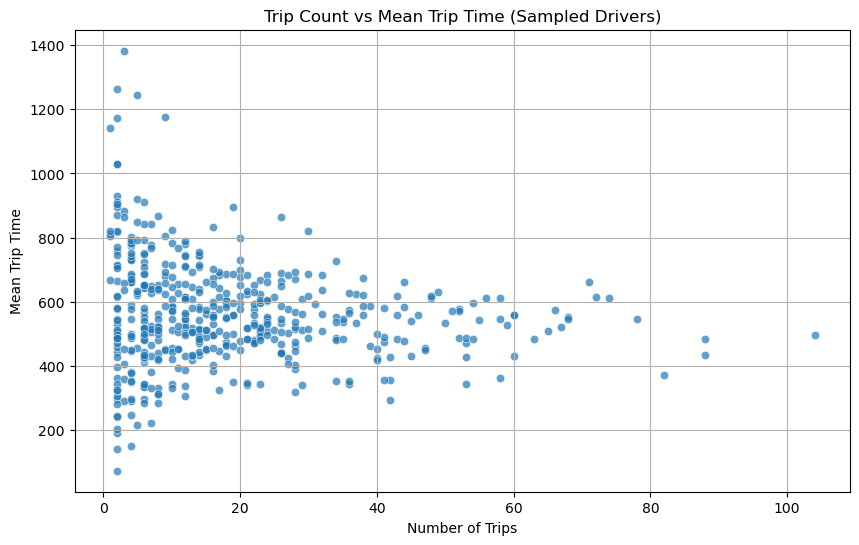

In [18]:
# Randomly sample 500 drivers for visualization
sampled_driver_stats = driver_stats.sample(500, random_state=42)

# Plot sampled data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_driver_stats, x='trip_count', y='mean_trip_time', alpha=0.7)
plt.title("Trip Count vs Mean Trip Time (Sampled Drivers)")
plt.xlabel("Number of Trips")
plt.ylabel("Mean Trip Time")
plt.grid()
plt.show()

/tmp/ipykernel_17592/1195054750.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_data, x='driverID', y='trip_time', palette='Set3')


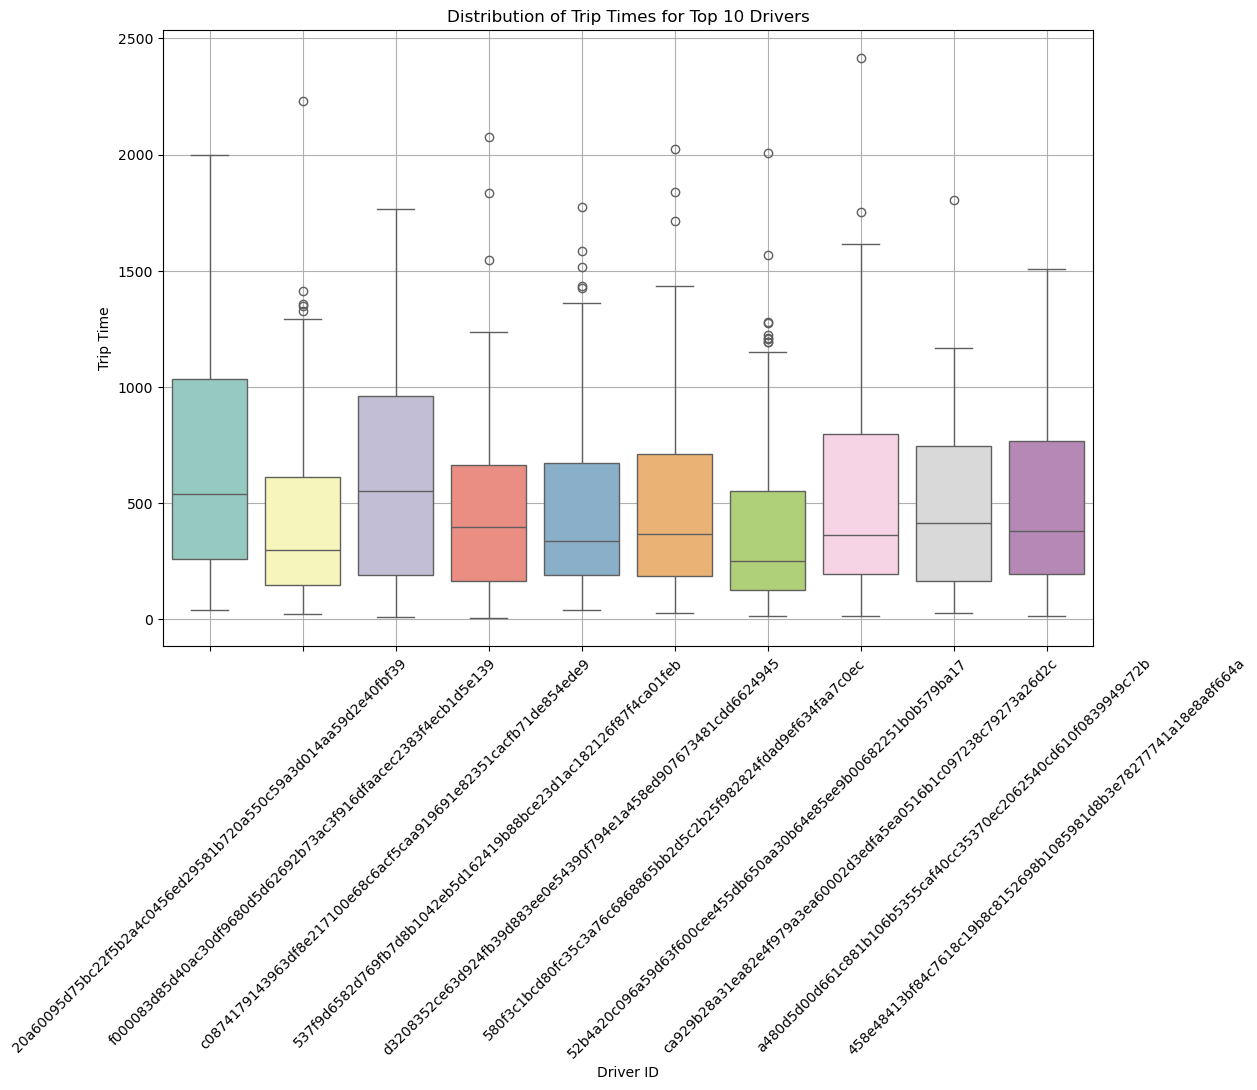

In [19]:
# Select a subset of drivers for detailed visualization
subset_drivers = road_df['driverID'].value_counts().nlargest(10).index

# Filter the data for these drivers
subset_data = road_df[road_df['driverID'].isin(subset_drivers)]

# Plot trip time distributions for each driver
plt.figure(figsize=(12, 8))
sns.boxplot(data=subset_data, x='driverID', y='trip_time', palette='Set3')
plt.title("Distribution of Trip Times for Top 10 Drivers")
plt.xlabel("Driver ID")
plt.ylabel("Trip Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [20]:
# Aggregate trip time by driver and week
weekly_performance = road_df.groupby(['driverID', 'weekID']).agg(
    mean_trip_time=('trip_time', 'mean'),
    total_distance=('dist', 'sum')
).reset_index()

# Select a sample driver to visualize over time
sample_driver = subset_drivers[8]  # Pick the first driver
driver_data = weekly_performance[weekly_performance['driverID'] == sample_driver]

/tmp/ipykernel_17592/561034906.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_data, x='driverID', y='residual', palette='coolwarm')


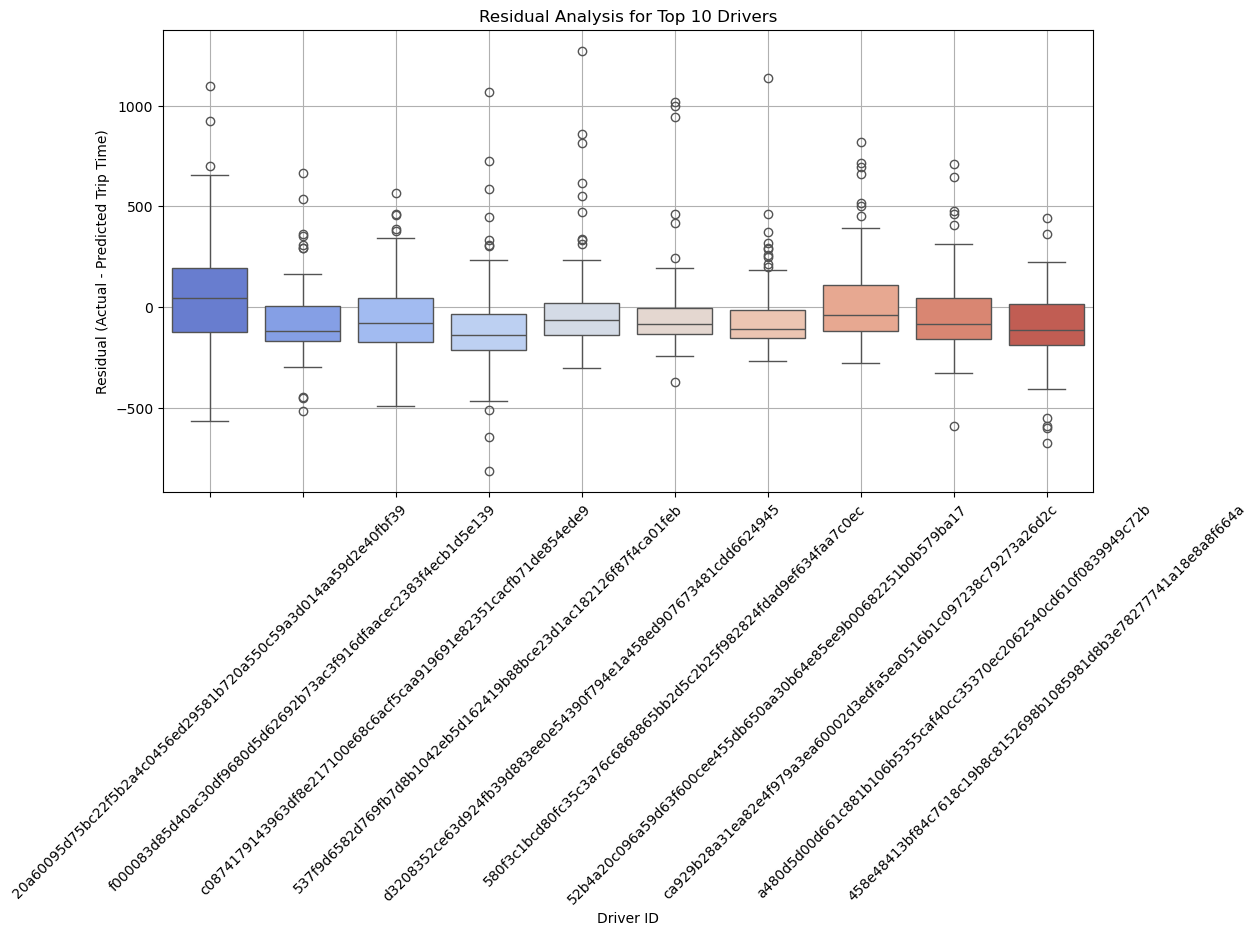

In [21]:
# Fit a regression model to predict trip time based on distance and other factors
X = road_df[['dist', 'segmentID', 'timeID']]
y = road_df['trip_time']
model = LinearRegression()
model.fit(X, y)
road_df['predicted_trip_time'] = model.predict(X)
road_df['residual'] = road_df['trip_time'] - road_df['predicted_trip_time']

# Plot residuals for the top drivers
subset_data = road_df[road_df['driverID'].isin(subset_drivers)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_data, x='driverID', y='residual', palette='coolwarm')
plt.title("Residual Analysis for Top 10 Drivers")
plt.xlabel("Driver ID")
plt.ylabel("Residual (Actual - Predicted Trip Time)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [22]:
time_segment_mapping = {
    '00:00 - 02:00': 0,
    '02:00 - 04:00': 1,
    '04:00 - 06:00': 2,
    '06:00 - 08:00': 3,
    '08:00 - 10:00': 4,
    '10:00 - 12:00': 5,
    '12:00 - 14:00': 6,
    '14:00 - 16:00': 7,
    '16:00 - 18:00': 8,
    '18:00 - 20:00': 9,
    '20:00 - 22:00': 10,
    '22:00 - 24:00': 11
}

road_df['two_hour_segment_encoded'] = road_df['two_hour_segment'].map(time_segment_mapping)

In [23]:
new_subset_drivers = road_df['driverID'].value_counts().nlargest(20).index

# Group by driverID and segmentID to calculate mean trip time
segment_behavior = road_df.groupby(['driverID', 'two_hour_segment_encoded']).agg(
    mean_trip_time=('trip_time', 'mean'),
    trip_count=('trip_time', 'count')
).reset_index()

# Visualize for top drivers
sampled_segment_data = segment_behavior[segment_behavior['driverID'].isin(new_subset_drivers)]

In [24]:
# Use all unique segments instead of restricting to the top ones
unique_segments = road_df['two_hour_segment_encoded'].unique().tolist()

# Filter data for all unique segments
filtered_data = road_df[road_df['two_hour_segment_encoded'].isin(unique_segments)]

# Calculate mean trip time per driver and segment
driver_segment_means = (
    filtered_data.groupby(['driverID', 'two_hour_segment_encoded'])['trip_time']
    .mean()
    .reset_index()
)

# Get the top 10 drivers with the most trips
top_drivers = road_df['driverID'].value_counts().head(10).index.tolist()

# Filter for top drivers
driver_segment_means = driver_segment_means[driver_segment_means['driverID'].isin(top_drivers)]

In [25]:
results = subset_data

In [ ]:
# # Add residuals to the results DataFrame
# results['residuals'] = results['actual_eta'] - results['predicted_eta']

# # Calculate residual statistics by driver and segment
# residual_analysis = (
#     results.merge(road_df[['trip_id', 'driverID', 'two_hour_segment_encoded']], on='trip_id')
#     .groupby(['driverID', 'two_hour_segment_encoded'])['residuals']
#     .agg(['mean', 'std', 'count'])
#     .reset_index()
# )

# # Filter for top drivers and top segments
# residual_analysis = residual_analysis[
#     residual_analysis['driverID'].isin(top_drivers) & residual_analysis['two_hour_segment_encoded'].isin(unique_segments)
# ]


KeyError: 'actual_eta'

#### Encoding

In [27]:
# Step 1: Compute Segment-Specific Statistics for Each Driver
segment_driver_stats = road_df.groupby(['two_hour_segment_encoded', 'driverID'])['trip_time'].agg(['mean', 'std']).reset_index()
segment_driver_stats.rename(columns={'mean': 'segment_mean_trip_time', 'std': 'segment_std_trip_time'}, inplace=True)

# Step 2: Merge Segment Statistics Back into the Main DataFrame
road_df = road_df.merge(segment_driver_stats, on=['two_hour_segment_encoded', 'driverID'], how='left')

In [28]:
# Step 1: Compute Overall Statistics per Driver
driver_overall_stats = road_df.groupby('driverID')['trip_time'].agg(['mean', 'std', 'count']).reset_index()
driver_overall_stats.rename(columns={'mean': 'overall_mean_trip_time', 'std': 'overall_std_trip_time', 'count': 'trip_count'}, inplace=True)

# Step 2: Compute Weighted Features (Weight = Trip Count)
driver_overall_stats['weighted_mean_trip_time'] = driver_overall_stats['overall_mean_trip_time'] * driver_overall_stats['trip_count']
driver_overall_stats['weighted_std_trip_time'] = driver_overall_stats['overall_std_trip_time'] * driver_overall_stats['trip_count']

# Step 3: Merge Weighted Encoding Back into the Main DataFrame
road_df = road_df.merge(driver_overall_stats[['driverID', 'weighted_mean_trip_time', 'weighted_std_trip_time']], on='driverID', how='left')

### Encode the Temporal Patterns (Time Segment) to follow a Cyclic Nature
Use Cyclic Encoding

In [29]:
# Assuming two_hour_segment_encoded ranges from 0 to 11 (representing 12 segments in 24 hours)
max_segment_value = road_df['two_hour_segment_encoded'].max()

# Apply cyclical encoding (sin and cos transformations)
road_df['two_hour_segment_sin'] = np.sin(2 * np.pi * road_df['two_hour_segment_encoded'] / (max_segment_value + 1))
road_df['two_hour_segment_cos'] = np.cos(2 * np.pi * road_df['two_hour_segment_encoded'] / (max_segment_value + 1))

#### Cyclic Encoding for weekday id

In [30]:
# Cyclical encoding for weekID (7 days in a week)
road_df['weekID_sin'] = np.sin(2 * np.pi * road_df['weekID'] / 7)
road_df['weekID_cos'] = np.cos(2 * np.pi * road_df['weekID'] / 7)

#### Cyclic Encoding for timeID

In [31]:
road_df['timeID_sin'] = np.sin(2 * np.pi * road_df['timeID'] / 1440)
road_df['timeID_cos'] = np.cos(2 * np.pi * road_df['timeID'] / 1440)
# Cyclical encoding for timeID (1440 minutes in a day)

### Create Interaction Terms between dist & time

In [32]:
# Creating interaction terms between distance and time-related features
road_df['dist_timeID_interaction'] = road_df['dist'] * road_df['timeID']
road_df['dist_two_hour_segment_interaction'] = road_df['dist'] * road_df['two_hour_segment_encoded']

In [33]:
# Creating interaction terms
road_df['dist_segment_mean'] = road_df['dist'] * road_df['segment_mean_trip_time']
road_df['dist_segment_std'] = road_df['dist'] * road_df['segment_std_trip_time']
road_df['dist_time_cos'] = road_df['dist'] * road_df['timeID_cos']
road_df['dist_time_sin'] = road_df['dist'] * road_df['timeID_sin']
road_df['segment_mean_time_cos'] = road_df['segment_mean_trip_time'] * road_df['timeID_cos']
road_df['segment_mean_time_sin'] = road_df['segment_mean_trip_time'] * road_df['timeID_sin']

In [34]:
interaction_columns = ['dist_segment_mean', 'dist_segment_std', 'dist_time_cos', 'dist_time_sin', 
                       'segment_mean_time_cos', 'segment_mean_time_sin']

## RFR Modeling

In [35]:
road_df.columns

Index(['trip_id', 'time_gap', 'dist', 'trip_time', 'driverID', 'weekID',
       'timeID', 'dateID', 'dist_gap', 'lats', 'lngs', 'time_offset',
       'segmentID', 'month', 'two_hour_segment', 'start_cluster_sting',
       'end_cluster_sting', 'same_cluster_sting', 'predicted_trip_time',
       'residual', 'two_hour_segment_encoded', 'segment_mean_trip_time',
       'segment_std_trip_time', 'weighted_mean_trip_time',
       'weighted_std_trip_time', 'two_hour_segment_sin',
       'two_hour_segment_cos', 'weekID_sin', 'weekID_cos', 'timeID_sin',
       'timeID_cos', 'dist_timeID_interaction',
       'dist_two_hour_segment_interaction', 'dist_segment_mean',
       'dist_segment_std', 'dist_time_cos', 'dist_time_sin',
       'segment_mean_time_cos', 'segment_mean_time_sin'],
      dtype='object')

Training Set Metrics:
RMSE: 132.88369489679388
MAE: 88.11829376058344
R² Score: 0.9042860787104161

Testing Set Metrics:
RMSE: 203.75820002507908
MAE: 138.27041291543748
R² Score: 0.7881644878765832


Feature Importance for Sting Model:
                    feature  importance
6         dist_segment_mean    0.711506
7          dist_segment_std    0.151464
2    segment_mean_trip_time    0.027677
3     segment_std_trip_time    0.019732
12      start_cluster_sting    0.012223
0                      dist    0.011927
10    segment_mean_time_cos    0.011391
5    weighted_std_trip_time    0.009126
11    segment_mean_time_sin    0.008614
8             dist_time_cos    0.007783
13        end_cluster_sting    0.007729
4   weighted_mean_trip_time    0.007413
1                timeID_cos    0.006877
9             dist_time_sin    0.006537


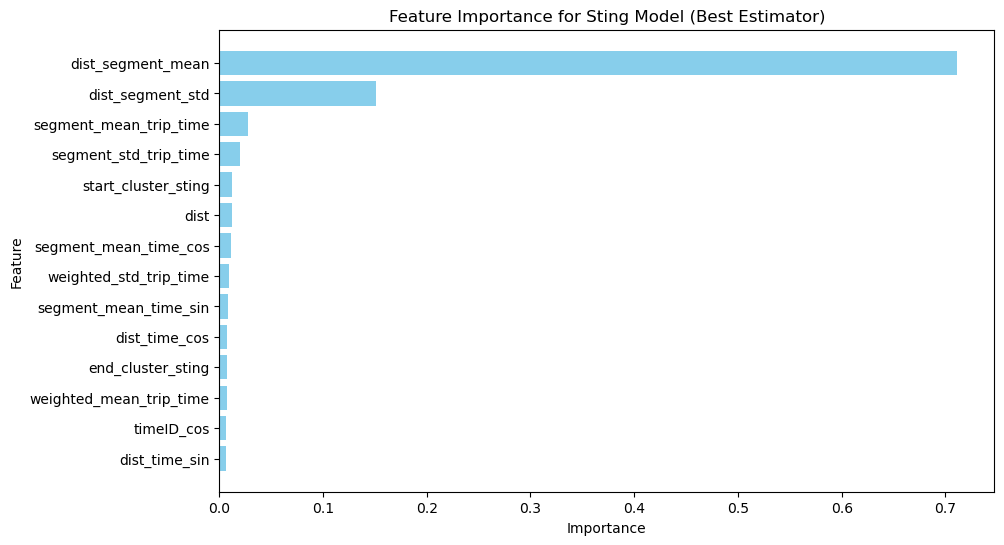

Results with trip IDs saved to ../Model Predictions/rfr_predictions.csv
Trained model for Sting saved as RFR_Model_Weights.pkl


In [37]:
feature_columns = ['dist', 'timeID_cos', 'segment_mean_trip_time', 'segment_std_trip_time', 'weighted_mean_trip_time', 'weighted_std_trip_time']

# add interaction terms to feature columns
feature_columns += interaction_columns

all_results = []  

# Define hyperparameter grid for Randomized Search
param_distributions = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

specific_features = feature_columns + [f'start_cluster_sting', f'end_cluster_sting']
target_column='trip_time'

# Define features and target (exclude trip_id from features but retain it for output)
X = road_df[specific_features]
y = road_df[target_column]
trip_ids = road_df['trip_id']  # Retain trip_id for traceability in the output

# Group by trip_id to ensure that trips are not split across training and testing sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups=trip_ids):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    trip_id_train, trip_id_test = trip_ids.iloc[train_idx], trip_ids.iloc[test_idx]


# Randomized Search for hyperparameter tuning
model = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_split=15, min_samples_leaf=4, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for the training set
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing set
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display the metrics
print("Training Set Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"R² Score: {train_r2}\n")

print("Testing Set Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R² Score: {test_r2}\n")



# Store the predictions and actual values along with trip_id for traceability
results = pd.DataFrame({
    'trip_id': trip_id_test,
    'actual_eta': y_test,
    'predicted_eta': y_test_pred,
    'algorithm': 'sting'
})


# Display feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': specific_features,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

print(f"\nFeature Importance for Sting Model:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for Sting Model (Best Estimator)')
plt.gca().invert_yaxis()  
plt.show()

output_csv = '../Model Predictions/rfr_predictions.csv'
results.to_csv(output_csv, index=False)
print(f"Results with trip IDs saved to {output_csv}")

# save model weights
model_filename = 'RFR_Model_Weights.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"Trained model for Sting saved as {model_filename}")

### Inspect Overfitting vs. Underfitting

#### Residual Plots

C:\Users\nadab\AppData\Local\Temp\ipykernel_10604\1696039688.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('third_train_results/residuals_vs_predicted_values.png')


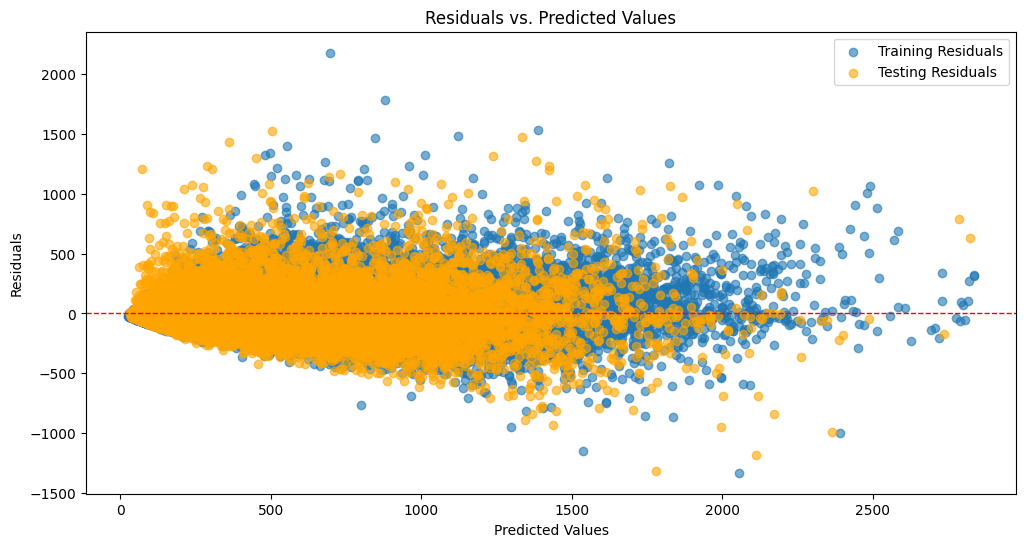

In [ ]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot residuals for training and testing sets
plt.figure(figsize=(12, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.6, label="Training Residuals")
plt.scatter(y_test_pred, test_residuals, alpha=0.6, label="Testing Residuals", color='orange')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.legend()
# plt.savefig('third_train_results/residuals_vs_predicted_values.png')
plt.show()


#### Training vs. Testing Predictions

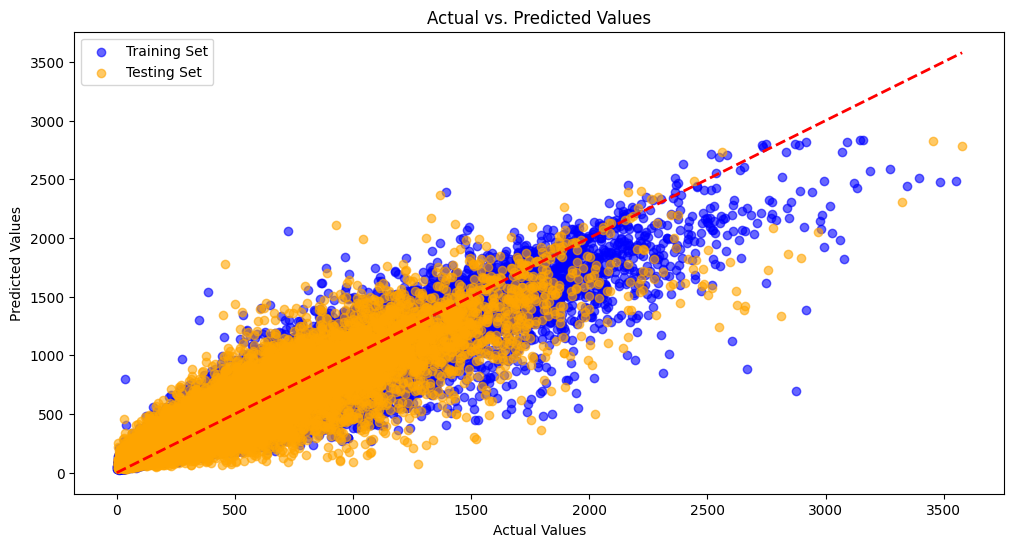

In [ ]:
# Plot actual vs. predicted values for training and testing sets
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6, label="Training Set", color='blue')
plt.scatter(y_test, y_test_pred, alpha=0.6, label="Testing Set", color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)  # Ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
# plt.savefig('third_train_results/actual_vs_predicted_values.png')
plt.show()

#### Learning Curves

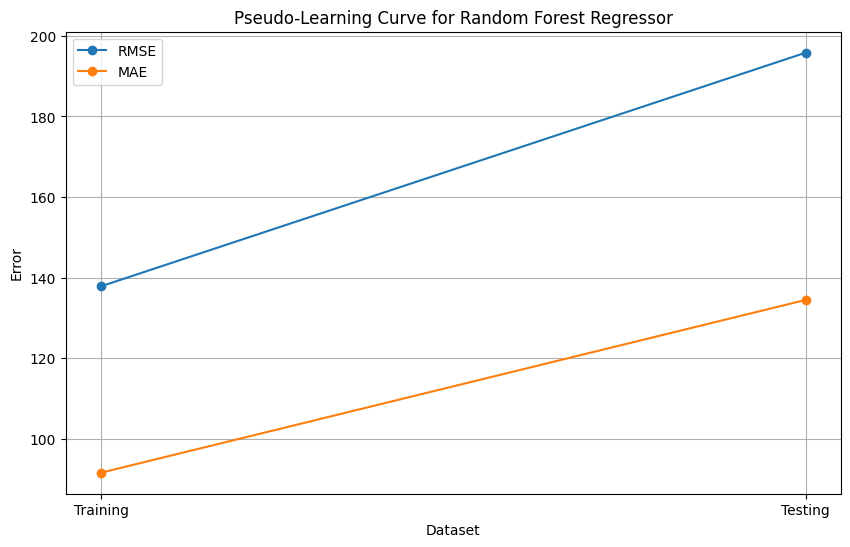

In [ ]:
# Plot pseudo-learning curve
plt.figure(figsize=(10, 6))
plt.plot(['Training', 'Testing'], [train_rmse, test_rmse], marker='o', label="RMSE")
plt.plot(['Training', 'Testing'], [train_mae, test_mae], marker='o', label="MAE")
plt.xlabel("Dataset")
plt.ylabel("Error")
plt.title("Pseudo-Learning Curve for Random Forest Regressor")
plt.legend()
plt.grid()
# plt.savefig('third_train_results/pseudo_learning_curve.png')
plt.show()


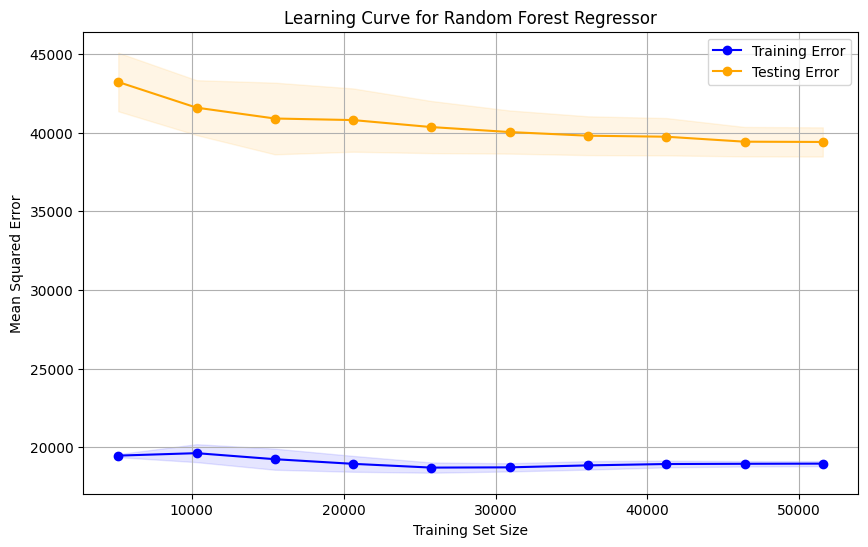

In [ ]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and std for training and testing scores
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Testing Error")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.1)
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve for Random Forest Regressor")
plt.legend()
plt.grid()
# plt.savefig('third_train_results/learning_curve.png')
plt.show()
